# 🍔👁 Food Vision Big™

In the previous notebook ([transfer learning part 3: scaling up](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb)) we built Food Vision mini: a transfer learning model which beat the original results of the [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/) with only 10% of the data.

But you might be wondering, what would happen if we used all the data?

Well, that's what we're going to find out in this notebook!

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

Yep. All 75,750 training images and 25,250 testing images.

And guess what...

This time **we've got the goal of beating [DeepFood](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)**, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.

> 🔑 **Note:** **Top-1 accuracy** means "accuracy for the top softmax activation value output by the model" (because softmax ouputs a value for every class, but top-1 means only the highest one is evaluated). **Top-5 accuracy** means "accuracy for the top 5 softmax activation values output by the model", in other words, did the true label appear in the top 5 activation values? Top-5 accuracy scores are usually noticeably higher than top-1.

|  | 🍔👁 Food Vision Big™ | 🍔👁 Food Vision mini |
|-----|-----|-----|
| Dataset source | TensorFlow Datasets | Preprocessed download from Kaggle |
| Train data | 75,750 images | 7,575 images |
| Test data | 25,250 images | 25,250 images |
| Mixed precision | Yes | No |
| Data loading | Performanant tf.data API | TensorFlow pre-built function |  
| Target results | 77.4% top-1 accuracy (beat [DeepFood paper](https://arxiv.org/abs/1606.05675)) | 50.76% top-1 accuracy (beat [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)) |

*Table comparing difference between Food Vision Big (this notebook) versus Food Vision mini (previous notebook).*



In [1]:
# Get GPU name
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-72d9b927-8b5a-cc3d-fe6b-812a478a4f2e)


In [2]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

import datetime
print(f"Notebook last run : {datetime.datetime.now()}")

TensorFlow version: 2.19.0
Notebook last run : 2026-02-09 09:12:23.789763


In [3]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to Download Data

In previous notebooks, we've downloaded our food images (from the [Food101 dataset](https://www.kaggle.com/dansbecker/food-101/home)) from Google Storage.

And this is a typical workflow you'd use if you're working on your own datasets.

However, there's another way to get datasets ready to use with TensorFlow.

For many of the most popular datasets in the machine learning world (often referred to and used as benchmarks), you can access them through [TensorFlow Datasets (TFDS)](https://www.tensorflow.org/datasets/overview).

What is **TensorFlow Datasets**?

A place for prepared and ready-to-use machine learning datasets.

Why use TensorFlow Datasets?

* Load data already in Tensors
* Practice on well established datasets
* Experiment with differet data loading techniques (like we're going to use in this notebook)
* Experiment with new TensorFlow features quickly (such as mixed precision training)

Why *not* use TensorFlow Datasets?

* The datasets are static (they don't change, like your real-world datasets would)
* Might not be suited for your particular problem (but great for experimenting)

To begin using TensorFlow Datasets we can import it under the alias `tfds`.


In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

To find all of the available datasets in TensorFlow Datasets, you can use the `list_builders()` method.

After doing so, we can check to see if the one we're after (`"food101"`) is present.

In [5]:
# Get all available datasets in TFDS
datasets_list = tfds.list_builders()

# Set our target dataset and see if it exists
target_dataset = "food101"
print(f"'{target_dataset}' in TensorFlow Datasets: {target_dataset in datasets_list}")

'food101' in TensorFlow Datasets: True


Beautiful! It looks like the dataset we're after is available (note there are plenty more available but we're on Food101).

To get access to the Food101 dataset from the TFDS, we can use the [`tfds.load()`](https://www.tensorflow.org/datasets/api_docs/python/tfds/load) method.

In particular, we'll have to pass it a few parameters to let it know what we're after:
* `name` (str) : the target dataset (e.g. `"food101"`)
* `split` (list, optional) : what splits of the dataset we're after (e.g. `["train", "validation"]`)
  * the `split` parameter is quite tricky. See [the documentation for more](https://github.com/tensorflow/datasets/blob/master/docs/splits.md).
* `shuffle_files` (bool) : whether or not to shuffle the files on download, defaults to `False`
* `as_supervised` (bool) : `True` to download data samples in tuple format (`(data, label)`) or `False` for dictionary format
* `with_info` (bool) : `True` to download dataset metadata (labels, number of samples, etc)

> 🔑 **Note:** Calling the `tfds.load()` method will start to download a target dataset to disk if the `download=True` parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [ ]:
# Load in the data
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle the files, not individual images
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

In [7]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [8]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
# Features of Food101 TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
ds_info.features["label"].num_classes

101

In [11]:
# Get class names
class_names = ds_info.features["label"].names

In [12]:
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Exploring the Food101 data from TensorFlow Datasets

Now we've downloaded the Food101 dataset from TensorFlow Datasets, how about we do what any good data explorer should?

In other words, "visualize, visualize, visualize".

Let's find out a few details about our dataset:
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus label-encoded)
* Do the labels match up with the class names?

To do, let's take one sample off the training data (using the [`.take()` method](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take)) and explore it.

> TFDS gives you unbatched data.

In [13]:
# Take one sample off the training data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

Because we used the `as_supervised=True` parameter in our `tfds.load()` method above, data samples come in the tuple format structure `(data, label)` or in our case `(image_tensor, label)`.

In [14]:
# What does one sample of our training data look like?
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

Let's loop through our single training sample and get some info from the `image_tensor` and `label`.

In [15]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (489, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 90
  Class name (str form): spaghetti_bolognese
        


Because we set the `shuffle_files=True` parameter in our `tfds.load()` method above, running the cell above a few times will give a different result each time.

Checking these you might notice some of the images have different shapes, for example `(512, 342, 3)` and `(512, 512, 3)` (height, width, color_channels).

Let's see what one of the image tensors from TFDS's Food101 dataset looks like.

In [16]:
# What does an image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(489, 512, 3), dtype=uint8, numpy=
array([[[ 83,  71,  45],
        [ 81,  69,  43],
        [ 80,  68,  44],
        ...,
        [186, 183, 142],
        [188, 185, 144],
        [185, 182, 141]],

       [[ 86,  74,  48],
        [ 83,  71,  45],
        [ 82,  70,  46],
        ...,
        [180, 177, 136],
        [179, 176, 135],
        [182, 179, 138]],

       [[ 88,  76,  52],
        [ 87,  75,  51],
        [ 85,  73,  49],
        ...,
        [188, 185, 144],
        [186, 183, 142],
        [187, 184, 143]],

       ...,

       [[162, 163, 168],
        [164, 165, 170],
        [171, 170, 176],
        ...,
        [ 75,  74,  56],
        [ 67,  66,  48],
        [ 64,  63,  45]],

       [[168, 169, 174],
        [175, 176, 181],
        [167, 166, 172],
        ...,
        [ 79,  78,  60],
        [ 74,  73,  55],
        [ 79,  78,  60]],

       [[182, 183, 188],
        [178, 179, 184],
        [163, 164, 169],
        ...,
        [ 75,  74,  5

In [17]:
# What are the min and max values?
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Alright looks like our image tensors have values of between 0 & 255 (standard red, green, blue colour values) and the values are of data type `unit8`.

We might have to preprocess these before passing them to a neural network. But we'll handle this later.

In the meantime, let's see if we can plot an image sample.

### Plot an image from TensorFlow Datasets

We've seen our image tensors in tensor format, now let's really adhere to our motto.

"Visualize, visualize, visualize!"

Let's plot one of the image samples using [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) and set the title to target class name.

In [18]:
label

<tf.Tensor: shape=(), dtype=int64, numpy=90>

In [19]:
label.numpy()

np.int64(90)

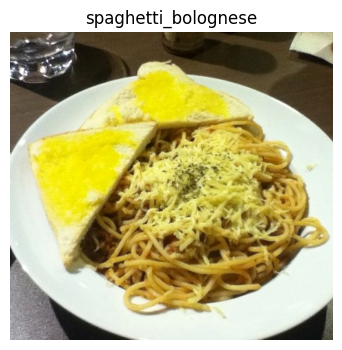

In [20]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.imshow(image)
plt.title(class_names[label.numpy()]) # add title to image by indexing on class_names list
plt.axis(False);

<h3> Delicious!


## Create preprocessing functions for our data

In previous notebooks, when our images were in folder format we used the method [`tf.keras.utils.image_dataset_from_directory()`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) to load them in.

Doing this meant our data was loaded into a format ready to be used with our models.

However, since we've downloaded the data from TensorFlow Datasets, there are a couple of preprocessing steps we have to take before it's ready to model.

More specifically, our data is currently:

* In `uint8` data type
* Comprised of all differnet sized tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In `float32` data type
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. `(224, 224, 3)`)
* Scaled (values between 0 & 1), also called normalized

To take care of these, we'll create a `preprocess_img()` function which:

* Resizes an input image tensor to a specified size using [`tf.image.resize()`](https://www.tensorflow.org/api_docs/python/tf/image/resize)
* Converts an input image tensor's current datatype to `tf.float32` using [`tf.cast()`](https://www.tensorflow.org/api_docs/python/tf/cast)

> 🔑 **Note:** Pretrained EfficientNetBX models in [`tf.keras.applications.efficientnet`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet) (what we're going to be using) have rescaling built-in. But for many other model architectures you'll want to rescale your data (e.g. get its values between 0 & 1). This could be incorporated inside your "`preprocess_img()`" function (like the one below) or within your model as a [`tf.keras.layers.Rescaling`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling) layer.

In [21]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """

    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    # image = image/255. # normalization
    image = tf.cast(image, tf.float32)
    return (image, label) # return (float32_image, label) tuple

Our `preprocess_img()` function above takes image and label as input (even though it does nothing to the label) because our dataset is currently in the tuple structure `(image, label)`.

Let's try our function out on a target image.

In [22]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[ 83  71  45]
  [ 81  69  43]
  [ 80  68  44]
  ...
  [186 183 142]
  [188 185 144]
  [185 182 141]]

 [[ 86  74  48]
  [ 83  71  45]
  [ 82  70  46]
  ...
  [180 177 136]
  [179 176 135]
  [182 179 138]]]...,
Shape: (489, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[ 83.108574  71.108574  45.108578]
  [ 82.11161   70.11161   46.11161 ]
  [ 84.873245  72.873245  49.30182 ]
  ...
  [191.5464   188.5464   147.5464  ]
  [184.01991  181.01991  140.01991 ]
  [182.87247  179.87247  138.87247 ]]

 [[ 87.08051   75.08051   51.080517]
  [ 84.33609   72.33609   48.336098]
  [ 83.439735  70.796875  47.439735]
  ...
  [198.13402  195.13402  154.13402 ]
  [194.08138  191.08138  150.08138 ]
  [193.38318  190.38318  149.38318 ]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


Excellent! Looks like our `preprocess_img()` function is working as expected.

The input image gets converted from `uint8` to `float32` and gets reshaped from its current shape to `(224, 224, 3)`.

How does it look?

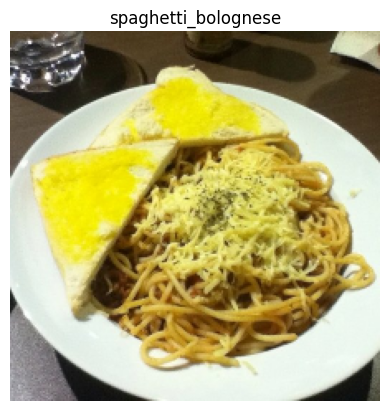

In [23]:
# We can still plot our preprocessed image as long as we
plt.imshow(preprocessed_img/255.)
plt.title(class_names[label])
plt.axis(False);

All this food visualization is making me hungry. How about we start preparing to model it?

## Batch & prepare datasets

Before we can model our data, we have to turn it into batches.

Why?

Because computing on batches is memory efficient.

We turn our data from 101,000 image tensors and labels (train and test combined) into batches of 32 image and label pairs, thus enabling it to fit into the memory of our GPU.

To do this in effective way, we're going to be leveraging a number of methods from the [`tf.data` API](https://www.tensorflow.org/api_docs/python/tf/data).

> 📖 **Resource:** For loading data in the most performant way possible, see the TensorFlow docuemntation on [Better performance with the tf.data API](https://www.tensorflow.org/guide/data_performance).

Specifically, we're going to be using:

* [`map()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map) - maps a predefined function to a target dataset (e.g. `preprocess_img()` to our image tensors)
* [`shuffle()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) - randomly shuffles the elements of a target dataset up `buffer_size` (ideally, the `buffer_size` is equal to the size of the dataset, however, this may have implications on memory)
* [`batch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) - turns elements of a target dataset into batches (size defined by parameter `batch_size`)
* [`prefetch()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) - prepares subsequent batches of data whilst other batches of data are being computed on (improves data loading speed but costs memory)
* Extra: [`cache()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) - caches (saves them for later) elements in a target dataset, saving loading time (will only work if your dataset is small enough to fit in memory, standard Colab instances only have 12GB of memory)

Things to note:
- Can't batch tensors of different shapes (e.g. different image sizes, need to reshape images first, hence our `preprocess_img()` function)
- `shuffle()` keeps a buffer of the number you pass it images shuffled, ideally this number would be all of the samples in your training set, however, if your training set is large, this buffer might not fit in memory (a fairly large number like 1000 or 10000 is usually suffice for shuffling)
- For methods with the `num_parallel_calls` parameter available (such as `map()`), setting it to`num_parallel_calls=tf.data.AUTOTUNE` will parallelize preprocessing and significantly improve speed
- Can't use `cache()` unless your dataset can fit in memory

Woah, the above is alot. But once we've coded below, it'll start to make sense.

We're going to through things in the following order:

```
Original dataset (e.g. train_data) -> map() -> shuffle() -> batch() -> prefetch() -> PrefetchDataset
```

This is like saying,

> "Hey, map this preprocessing function across our training dataset, then shuffle a number of elements before batching them together and make sure you prepare new batches (prefetch) whilst the model is looking through the current batch".

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-prefetching-from-hands-on-ml.png)

*What happens when you use prefetching (faster) versus what happens when you don't use prefetching (slower). **Source:** Page 422 of [Hands-On Machine Learning with Scikit-Learn, Keras & TensorFlow Book by Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/).*


In [24]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

In [25]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

And now let's check out what our prepared datasets look like.

In [26]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Excellent! Looks like our data is now in tutples of `(image, label)` with datatypes of `(tf.float32, tf.int64)`, just what our model is after.

> 🔑 **Note:** You can get away without calling the `prefetch()` method on the end of your datasets, however, you'd probably see significantly slower data loading speeds when building a model. So most of your dataset input pipelines should end with a call to [`prefecth()`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch).

Onward.

## Create modelling callbacks

Since we're going to be training on a large amount of data and training could take a long time, it's a good idea to set up some modelling callbacks so we be sure of things like our model's training logs being tracked and our model being checkpointed (saved) after various training milestones.

To do each of these we'll use the following callbacks:
* [`tf.keras.callbacks.TensorBoard()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard) - allows us to keep track of our model's training history so we can inspect it later (**note:** we've created this callback before have imported it from `helper_functions.py` as `create_tensorboard_callback()`)
* [`tf.keras.callbacks.ModelCheckpoint()`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint) - saves our model's progress at various intervals so we can load it and resuse it later without having to retrain it
  * Checkpointing is also helpful so we can start fine-tuning our model at a particular epoch and revert back to a previous state if fine-tuning offers no benefits

In [27]:
# Create TensorBoard callback (already have "create_tensorboard_callback()")
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints.weights.h5" # saving weights requires ".weights.h5" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Setup mixed precision training

We touched on mixed precision training above.

However, we didn't quite explain it.

Normally, tensors in TensorFlow default to the float32 datatype (unless otherwise specified).

In computer science, float32 is also known as [single-precision floating-point format](https://en.wikipedia.org/wiki/Single-precision_floating-point_format). The 32 means it usually occupies 32 bits in computer memory.

Your GPU has a limited memory, therefore it can only handle a number of float32 tensors at the same time.

This is where mixed precision training comes in.

Mixed precision training involves using a mix of float16 and float32 tensors to make better use of your GPU's memory.

Can you guess what float16 means?

Well, if you thought since float32 meant single-precision floating-point, you might've guessed float16 means [half-precision floating-point format](https://en.wikipedia.org/wiki/Half-precision_floating-point_format). And if you did, you're right! And if not, no trouble, now you know.

For tensors in float16 format, each element occupies 16 bits in computer memory.

So, where does this leave us?

As mentioned before, when using mixed precision training, your model will make use of float32 and float16 data types to use less memory where possible and in turn run faster (using less memory per tensor means more tensors can be computed on simultaneously).

As a result, using mixed precision training can improve your performance on modern GPUs (those with a compute capability score of 7.0+) by up to 3x.

For a more detailed explanation, I encourage you to read through the [TensorFlow mixed precision guide](https://www.tensorflow.org/guide/mixed_precision) (I'd highly recommend at least checking out the summary).

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-speedup-equals-3x-gpu.png)
*Because mixed precision training uses a combination of float32 and float16 data types, you may see up to a 3x speedup on modern GPUs.*

> 🔑 **Note:** If your GPU doesn't have a score of over 7.0+ (e.g. P100 in Google Colab), mixed precision won't work (see: ["Supported Hardware"](https://www.tensorflow.org/guide/mixed_precision#supported_hardware) in the mixed precision guide for more).

> 📖 **Resource:** If you'd like to learn more about precision in computer science (the detail to which a numerical quantity is expressed by a computer), see the [Wikipedia page](https://en.wikipedia.org/wiki/Precision_(computer_science)) (and accompanying resources).

Okay, enough talk, let's see how we can turn on mixed precision training in TensorFlow.

The beautiful thing is, the [`tensorflow.keras.mixed_precision`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/) API has made it very easy for us to get started.

First, we'll import the API and then use the [`set_global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/set_global_policy) method to set the *dtype policy* to `"mixed_float16"`.


In [28]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision

Nice! As long as the GPU you're using has a compute capability of 7.0+ the cell above should run without error.

Now we can check the global dtype policy (the policy which will be used by layers in our model) using the [`mixed_precision.global_policy()`](https://www.tensorflow.org/api_docs/python/tf/keras/mixed_precision/global_policy) method.

In [29]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<DTypePolicy "mixed_float16">

Great, since the global dtype policy is now `"mixed_float16"` our model will automatically take advantage of float16 variables where possible and in turn speed up training.

## Build feature extraction model

Callbacks: ready to roll.

Mixed precision: turned on.

Let's build a model.

Because our dataset is quite large, we're going to move towards fine-tuning an existing pretrained model (EfficienetNetB0).

But before we get into fine-tuning, let's set up a feature-extraction model.

Recall, the typical order for using transfer learning is:

1. Build a feature extraction model (replace the top few layers of a pretrained model)
2. Train for a few epochs with lower layers frozen
3. Fine-tune if necessary with multiple layers unfrozen

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-feature-extraction-then-fine-tune.png)
*Before fine-tuning, it's best practice to train a feature extraction model with custom top layers.*

To build the feature extraction model (covered in [Transfer Learning in TensorFlow Part 1: Feature extraction](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/04_transfer_learning_in_tensorflow_part_1_feature_extraction.ipynb)), we'll:
* Use `EfficientNetB0` from [`tf.keras.applications`](https://www.tensorflow.org/api_docs/python/tf/keras/applications) pre-trained on ImageNet as our base model
  * We'll download this without the top layers using `include_top=False` parameter so we can create our own output layers
* Freeze the base model layers so we can use the pre-learned patterns the base model has found on ImageNet
* Put together the input, base model, pooling and output layers in a [Functional model](https://keras.io/guides/functional_api/)
* Compile the Functional model using the Adam optimizer and [sparse categorical crossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function (since our labels **aren't** one-hot encoded)
* Fit the model for 3 epochs using the TensorBoard and ModelCheckpoint callbacks

> 🔑 **Note:** Since we're using mixed precision training, our model needs a separate output layer with a hard-coded `dtype=float32`, for example, `layers.Activation("softmax", dtype=tf.float32)`. This ensures the outputs of our model are returned back to the float32 data type which is more numerically stable than the float16 datatype (important for loss calculations). See the ["Building the model"](https://www.tensorflow.org/guide/mixed_precision#building_the_model) section in the TensorFlow mixed precision guide for more.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/07-mixed-precision-code-before-and-after.png)
*Turning mixed precision on in TensorFlow with 3 lines of code.*

<h3> Let's build Data Augmentation layer:

In [30]:
from tensorflow.keras import layers, Input

data_augmentation = tf.keras.Sequential([
    Input(shape=(224, 224, 3)), # to make sure all images has the same shape
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")

<h3>EfficientNetB0 - Baseline

In [31]:
# 1) create base_model
base_model_effv2 = tf.keras.applications.EfficientNetV2B0(include_top=False, weights="imagenet")
base_model_effv2.trainable = False

# 2) Input Layer
inputs = tf.keras.Input(shape=(224, 224, 3), name="Input_layer")

# 3) add data_augmentation layer
x = data_augmentation(inputs) # optional

# 4) Normalization (always) -> (skip – EfficientNetV2 handles it internally)
# x = tf.keras.layers.Rescaling(1./255)(x)

# 5) Feature extraction
x = base_model_effv2(x, training=False) # set base_model to inference mode only

# 6) Pooling
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# 7) Output Layer
x = tf.keras.layers.Dense(len(class_names))(x) # want one output neuron per class
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) # to use mixed_precision

# 8) Build Model
model_effv2 = tf.keras.Model(inputs, outputs, name="EfficientNetV2B0")

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [32]:
# Compile the model
model_effv2.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [33]:
# Check out our model
model_effv2.summary()

Model: "EfficientNetV2B0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b0 (Functional)  │ (None, 7, 7, 1280)     │     5,919,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 101)            │       129,381 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,048,693 (23.07 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

`EfficientNetV2B0` was initially selected as a lightweight baseline model due to its strong performance-to-parameter ratio. To evaluate the impact of architectural depth and residual connections, `ConvNeXtTiny` was subsequently used as an alternative backbone. This comparison allowed an analysis of efficiency-oriented versus depth-oriented convolutional architectures on the Food-101 dataset.

<h3> ConvNeXtTiny

In [34]:
# 1) create base_model
base_model_convnext = tf.keras.applications.ConvNeXtTiny(include_top=False, weights="imagenet")
base_model_convnext.trainable = False

# 2) Input Layer
inputs = tf.keras.Input(shape=(224, 224, 3), name="Input_layer")

# 3) add data_augmentation layer
x = data_augmentation(inputs)  # optional

# 4) Normalization (skip – ConvNeXt has it built-in)

# 5) Feature extraction
x = base_model_convnext(x, training=False)

# 6) Pooling
x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)

# 7) Output Layer
x = tf.keras.layers.Dense(len(class_names))(x)
outputs = tf.keras.layers.Activation("softmax",dtype=tf.float32,name="softmax_float32")(x)

# 8) Build Model
model_convnext = tf.keras.Model(inputs, outputs, name="ConvNeXtTiny")

111650432/111650432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [35]:
# Compile the model
model_convnext.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [36]:
model_convnext.summary()

Model: "ConvNeXtTiny"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_tiny (Functional)      │ (None, 7, 7, 768)      │    27,820,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pooling_layer                   │ (None, 768)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │        77,669 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_float32 (Activation)    │ (None, 101)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,897,797 (106.42 MB)

 Trainable params: 77,669 (303.39 KB)

 Non-trainable params: 27,820,128 (106.13 MB)

## Fit the feature extraction model

Now that's one good looking model. Let's fit it to our data shall we?

Three epochs should be enough for our top layers to adjust their weights enough to our food image data.

To save time per epoch, we'll also only validate on 15% of the test data.

<h3> Fit EfficientNetV2B0 (Experiment 1)

In [37]:
# checkpoint for this model (weights only)
checkpoint_path_effv2 = "checkpoints/effnetv2_best.weights.h5"
model_checkpoint_effv2 = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path_effv2,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [39]:
EPOCHS = 10

history_effv2 = model_effv2.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
    callbacks=[
        create_tensorboard_callback(dir_name="logs", experiment_name="EffNetV2B0"),
        model_checkpoint_effv2
    ]
)

Saving TensorBoard log files to: logs/EffNetV2B0/20260209-092722
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4720 - loss: 2.1803
Epoch 1: val_accuracy improved from -inf to 0.63822, saving model to checkpoints/effnetv2_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 272s 114ms/step - accuracy: 0.4720 - loss: 2.1803 - val_accuracy: 0.6382 - val_loss: 1.3506
Epoch 2/10
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5418 - loss: 1.8151
Epoch 2: val_accuracy improved from 0.63822 to 0.66788, saving model to checkpoints/effnetv2_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 233s 97ms/step - accuracy: 0.5418 - loss: 1.8151 - val_accuracy: 0.6679 - val_loss: 1.2413
Epoch 3/10
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.5680 - loss: 1.6928
Epoch 3: val_accuracy improved from 0.66788 to 0.67992, saving model to checkpoints/effnetv2_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 97ms/step - accuracy: 0.5680 - loss: 1.6928 - val_accuracy: 0.6

<h3> Fit ConvNeXtTiny (Experiment 2)

- Use a different checkpoint file to avoid overwriting.

In [40]:
# checkpoint for this model (weights only)
checkpoint_path_convnext = "checkpoints/convnexttiny_best.weights.h5"
model_checkpoint_convnext = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path_convnext,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

In [41]:
EPOCHS = 5

history_convnext = model_convnext.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=test_data,
    callbacks=[
        create_tensorboard_callback(dir_name="logs", experiment_name="ConvNeXtTiny"),
        model_checkpoint_convnext]
)

Saving TensorBoard log files to: logs/ConvNeXtTiny/20260209-100833
Epoch 1/5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3633 - loss: 2.7942
Epoch 1: val_accuracy improved from -inf to 0.59691, saving model to checkpoints/convnexttiny_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 569s 218ms/step - accuracy: 0.3634 - loss: 2.7940 - val_accuracy: 0.5969 - val_loss: 1.5139
Epoch 2/5
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5524 - loss: 1.7817
Epoch 2: val_accuracy improved from 0.59691 to 0.63877, saving model to checkpoints/convnexttiny_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 463s 193ms/step - accuracy: 0.5524 - loss: 1.7817 - val_accuracy: 0.6388 - val_loss: 1.3412
Epoch 3/5
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5871 - loss: 1.6207
Epoch 3: val_accuracy improved from 0.63877 to 0.64844, saving model to checkpoints/convnexttiny_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 459s 193ms/step - accuracy: 0.5871 - loss: 1.6207 - v

<h3> Plot EfficientNetV2B0 Curves

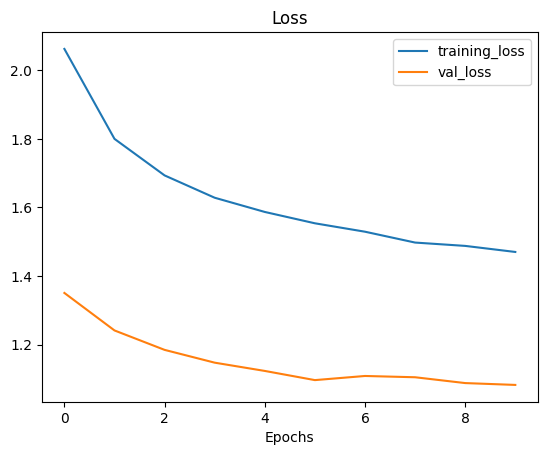

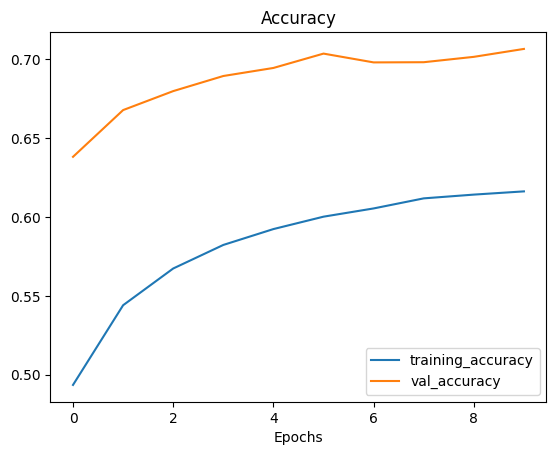

In [42]:
# from helper_functions import plot_loss_curves, compare_historys

plot_loss_curves(history_effv2)

<h3> Plot ConvNeXtTiny Curves

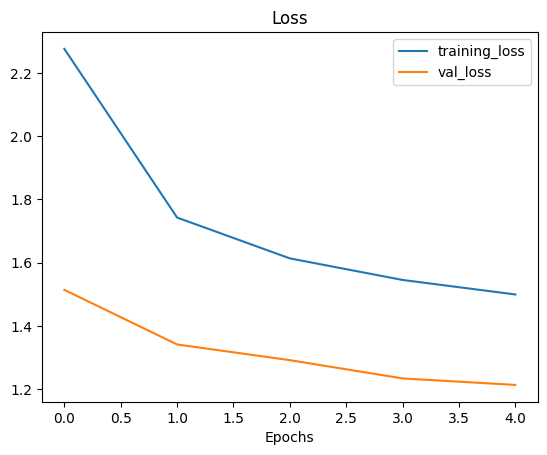

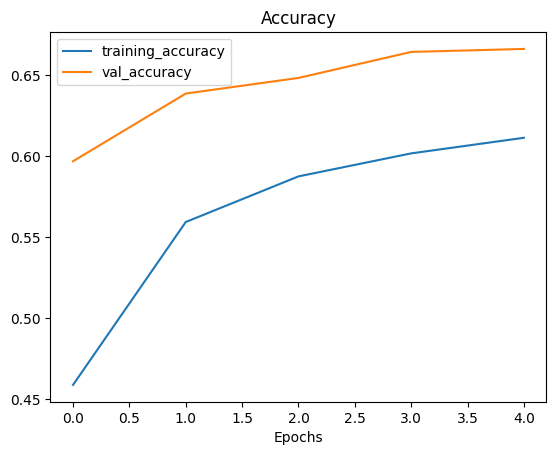

In [43]:
plot_loss_curves(history_convnext)

<h3> Launch TensorBoard

In [44]:
# %load_ext tensorboard
# %tensorboard --logdir logs

TensorBoard was used to monitor and compare the training and validation performance of EfficientNetB0 and ResNet50 under identical experimental settings, enabling a clear analysis of convergence behavior and generalization performance.

## Checking layer dtype policies (are we using mixed precision?)

Model ready to go!

Before we said the mixed precision API will automatically change our layers' dtype policy's to whatever the global dtype policy is (in our case it's `"mixed_float16"`).

We can check this by iterating through our model's layers and printing layer attributes such as `dtype` and `dtype_policy`.

In [45]:
# Check the dtype_policy attributes of layers in our model
for layer in model_effv2.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

Input_layer True float32 <DTypePolicy "mixed_float16">
data_augmentation True float32 <DTypePolicy "mixed_float16">
efficientnetv2-b0 False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


In [46]:
# Check the dtype_policy attributes of layers in our model
for layer in model_convnext.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy) # Check the dtype policy of layers

Input_layer True float32 <DTypePolicy "mixed_float16">
data_augmentation True float32 <DTypePolicy "mixed_float16">
convnext_tiny False float32 <DTypePolicy "mixed_float16">
pooling_layer True float32 <DTypePolicy "mixed_float16">
dense_1 True float32 <DTypePolicy "mixed_float16">
softmax_float32 True float32 <DTypePolicy "float32">


Going through the above we see:
* `layer.name` (str) : a layer's human-readable name, can be defined by the `name` parameter on construction
* `layer.trainable` (bool) : whether or not a layer is trainable (all of our layers are trainable except the efficientnetb0 layer since we set it's `trainable` attribute to `False`
* `layer.dtype` : the data type a layer stores its variables in
* `layer.dtype_policy` : the data type a layer computes in

> 🔑 **Note:** A layer can have a dtype of `float32` and a dtype policy of `"mixed_float16"` because it stores its variables (weights & biases) in `float32` (more numerically stable), however it computes in `float16` (faster).

We can also check the same details for our model's base model.


In [47]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model_effv2.layers[2].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_1 False float32 <DTypePolicy "mixed_float16">
rescaling False float32 <DTypePolicy "mixed_float16">
normalization False float32 <DTypePolicy "mixed_float16">
stem_conv False float32 <DTypePolicy "mixed_float16">
stem_bn False float32 <DTypePolicy "mixed_float16">
stem_activation False float32 <DTypePolicy "mixed_float16">
block1a_project_conv False float32 <DTypePolicy "mixed_float16">
block1a_project_bn False float32 <DTypePolicy "mixed_float16">
block1a_project_activation False float32 <DTypePolicy "mixed_float16">
block2a_expand_conv False float32 <DTypePolicy "mixed_float16">
block2a_expand_bn False float32 <DTypePolicy "mixed_float16">
block2a_expand_activation False float32 <DTypePolicy "mixed_float16">
block2a_project_conv False float32 <DTypePolicy "mixed_float16">
block2a_project_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_conv False float32 <DTypePolicy "mixed_float16">
block2b_expand_bn False float32 <DTypePolicy "mixed_float16">
block2b_expand_

In [48]:
# Check the layers in the base model and see what dtype policy they're using
for layer in model_convnext.layers[2].layers[:20]: # only check the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer_2 False float32 <DTypePolicy "mixed_float16">
convnext_tiny_prestem_normalization False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stem False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_0_depthwise_conv False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_0_layernorm False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_0_pointwise_conv_1 False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_0_gelu False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_0_pointwise_conv_2 False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_0_layer_scale False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_0_identity False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_1_depthwise_conv False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_block_1_layernorm False float32 <DTypePolicy "mixed_float16">
convnext_tiny_stage_0_b

> 🔑 **Note:** The mixed precision API automatically causes layers which can benefit from using the `"mixed_float16"` dtype policy to use it. It also prevents layers which shouldn't use it from using it (e.g. the normalization layer at the start of the base model).

Nice, looks like our feature extraction model is performing pretty well. How about we evaluate it on the whole test dataset?

## 🔓 Fine-tune both models

### A) Fine-tune EfficientNetV2B0

In [49]:
model_effv2.load_weights("checkpoints/effnetv2_best.weights.h5")

In [50]:
# sanity check: evaluate BEFORE fine-tune
model_effv2.evaluate(test_data, verbose=0)

[1.0824182033538818, 0.7066930532455444]

In [51]:
base_model_effv2.trainable = True

# train only last 20% of layers
fine_tune_at = int(len(base_model_effv2.layers) * 0.8)
for layer in base_model_effv2.layers[:fine_tune_at]:
    layer.trainable = False

# keep BatchNorm frozen (important for stability)
for layer in base_model_effv2.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False


model_effv2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
    metrics=["accuracy"]
)

In [53]:
EPOCHS = 10
FINE_TUNE_EPOCHS = 10

history_effv2_finetune = model_effv2.fit(
    train_data,
    epochs=EPOCHS + FINE_TUNE_EPOCHS,   # if EPOCHS = 10 => total 20
    initial_epoch=EPOCHS,              # start at 10 (so next is epoch 11)
    validation_data=test_data,
    callbacks=[
        create_tensorboard_callback("logs", "EffNetV2B0_finetune_safe"),
        model_checkpoint_effv2
    ]
)

Saving TensorBoard log files to: logs/EffNetV2B0_finetune_safe/20260209-105516
Epoch 11/20
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6577 - loss: 1.3025
Epoch 11: val_accuracy improved from 0.72234 to 0.72737, saving model to checkpoints/effnetv2_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 256s 107ms/step - accuracy: 0.6577 - loss: 1.3025 - val_accuracy: 0.7274 - val_loss: 0.9984
Epoch 12/20
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.6674 - loss: 1.2709
Epoch 12: val_accuracy improved from 0.72737 to 0.73053, saving model to checkpoints/effnetv2_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 258s 108ms/step - accuracy: 0.6674 - loss: 1.2709 - val_accuracy: 0.7305 - val_loss: 0.9870
Epoch 13/20
2367/2368 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.6686 - loss: 1.2536
Epoch 13: val_accuracy improved from 0.73053 to 0.73248, saving model to checkpoints/effnetv2_best.weights.h5
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 109ms/step - accuracy: 0.6686 - loss: 1

### B) Fine-tune ConvNeXtTiny

> Will take a lot of time

In [54]:
# base_model_convnext = tf.keras.applications.ConvNeXtTiny(include_top=False, weights="imagenet")
# base_model_convnext.trainable = False

# inputs = tf.keras.Input(shape=(224, 224, 3), name="Input_layer")
# x = data_augmentation(inputs)
# x = base_model_convnext(x, training=False)
# x = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = tf.keras.layers.Dense(len(class_names))(x)
# outputs = tf.keras.layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)

# model_convnext = tf.keras.Model(inputs, outputs, name="ConvNeXtTiny")

In [55]:
# model_convnext.load_weights("checkpoints/convnexttiny_best.weights.h5")

In [56]:
# # Compile the model
# model_convnext.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
#               optimizer=tf.keras.optimizers.Adam(),
#               metrics=["accuracy"])

In [57]:
# model_convnext.evaluate(test_data, verbose=0)

In [58]:
# base_model_convnext.trainable = True

# # train only last 20% of layers
# fine_tune_at = int(len(base_model_convnext.layers) * 0.8)
# for layer in base_model_convnext.layers[:fine_tune_at]:
#     layer.trainable = False

# model_convnext.compile(
#     loss="sparse_categorical_crossentropy",
#     optimizer=tf.keras.optimizers.Adam(learning_rate=3e-6),
#     metrics=["accuracy"]
# )

In [59]:
# FINE_TUNE_EPOCHS = 5

# history_convnext_finetune = model_convnext.fit(
#     train_data,
#     epochs=EPOCHS + FINE_TUNE_EPOCHS,   # total epochs (e.g. 10)
#     initial_epoch=EPOCHS,              # start from epoch 6
#     validation_data=test_data,
#     callbacks=[
#         create_tensorboard_callback("logs", "ConvNeXtTiny_finetune_safe"),
#         model_checkpoint_convnext
#     ]
# )

## Decide the winner

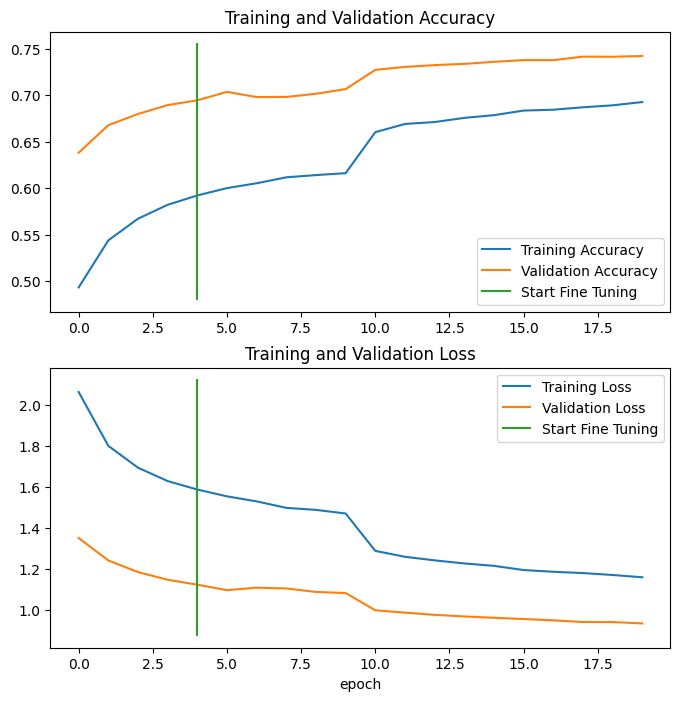

In [60]:
compare_historys(history_effv2, history_effv2_finetune)

In [61]:
# %load_ext tensorboard
# %tensorboard --logdir logs

In [62]:
# EfficientNetV2
model_effv2.load_weights("checkpoints/effnetv2_best.weights.h5")
eff_loss, eff_acc = model_effv2.evaluate(test_data, verbose=0)

# ConvNeXtTiny
model_convnext.load_weights("checkpoints/convnexttiny_best.weights.h5")
cnx_loss, cnx_acc = model_convnext.evaluate(test_data, verbose=0)

print("EffNetV2B0  -> val_acc:", eff_acc, "val_loss:", eff_loss)
print("ConvNeXtTiny-> val_acc:", cnx_acc, "val_loss:", cnx_loss)

EffNetV2B0  -> val_acc: 0.7422574162483215 val_loss: 0.9343411922454834
ConvNeXtTiny-> val_acc: 0.6663762331008911 val_loss: 1.2132147550582886


<h3> EfficientNetV2 🥇

In [63]:
# Save the FULL model
import os
os.makedirs("exports", exist_ok=True) # create folder
model_effv2.save("exports/foodvision_effnetv2.keras")

In [64]:
# loaded_model = tf.keras.models.load_model("foodvision_effnetv2.keras")
# loaded_model.evaluate(test_data, verbose=0)

## Try models on real food images

1) Load best model

In [65]:
model = tf.keras.models.load_model("foodvision_effnetv2.keras")

2) Load Image

In [66]:
from helper_functions import load_and_prep_image, pred_and_plot

# One image
# img_path = ""
# img = load_and_prep_image(img_path)

# Multiple images
image_paths = [
   '/content/hamzah_pizza.jpeg',
   '/content/ahmad_pizza.jpeg',
   '/content/zwiri_pizza.jpeg'
]

3) Use `load_and_prep_image()`

In [67]:
for p in image_paths:
    img = load_and_prep_image(p, scale=False)
    pred_probs = model.predict(tf.expand_dims(img, axis=0), verbose=0)
    pred_class = class_names[int(tf.argmax(pred_probs[0]))]
    confidence = float(tf.reduce_max(pred_probs[0]))
    print(p, "->", pred_class, f"({confidence:.2%})")

/content/hamzah_pizza.jpeg -> lobster_roll_sandwich (51.88%)
/content/ahmad_pizza.jpeg -> pizza (47.91%)
/content/zwiri_pizza.jpeg -> pizza (84.09%)


4) Visualization

In [68]:
import numpy as np
def load_for_display_and_model(image_path, img_size=224):
    # Read + decode
    img_bytes = tf.io.read_file(image_path)
    img = tf.image.decode_image(img_bytes, channels=3)
    img.set_shape([None, None, 3])

    # Keep a copy for display (uint8 0..255)
    img_display = tf.cast(img, tf.uint8)

    # Prepare for model (resize + float32)
    img_model = tf.image.resize(img, (img_size, img_size))
    img_model = tf.cast(img_model, tf.float32)  # values still 0..255

    return img_display, img_model

def predict_and_show(model, image_path, class_names):
    img_display, img_model = load_for_display_and_model(image_path)

    # Predict (batch of 1)
    probs = model.predict(tf.expand_dims(img_model, axis=0), verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names[pred_idx]
    conf = float(np.max(probs))

    # Show ORIGINAL image (not normalized)
    plt.figure(figsize=(6, 6))
    plt.imshow(img_display)
    plt.title(f"Prediction: {pred_name} ({conf:.2%})")
    plt.axis("off")
    plt.show()

    return pred_name, conf

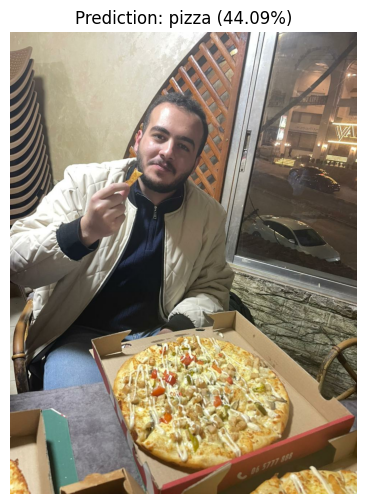

('pizza', 0.44093450903892517)

In [69]:
predict_and_show(model_effv2, "/content/ahmad_pizza.jpeg", class_names)

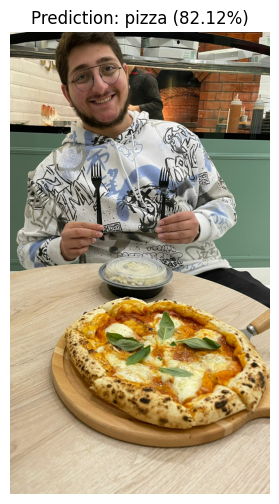

('pizza', 0.821240246295929)

In [70]:
predict_and_show(model_effv2, "/content/zwiri_pizza.jpeg", class_names)